In [1]:
import cv2
import numpy as np
import requests
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from io import BytesIO

In [2]:
# Function to load an image from a path or URL
def load_image(source):
    if source.startswith('http://') or source.startswith('https://'):
        response = requests.get(source)
        image = Image.open(BytesIO(response.content)).convert("RGBA")
    else:
        image = Image.open(source).convert("RGBA")
    return image

In [3]:
Rojas='https://cdn.vox-cdn.com/thumbor/BKb1MPY8udBqfY5HC3jkE6VCQuA=/1400x1050/filters:format(jpeg)/cdn.vox-cdn.com/uploads/chorus_asset/file/24282344/1448244135.jpg'
Mike_Perry='https://www.mmaweekly.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MjAyNjQ0MjYxNjU5ODEyODc2/95-mike-perry-vs-eddie-alvarez-bkfc-56.jpg'

In [4]:
# Load the image (from URL for now)
image_url = Mike_Perry
image = load_image(image_url)
image_rgb = image.convert("RGB")  # Convert to RGB
image_np = np.array(image_rgb)

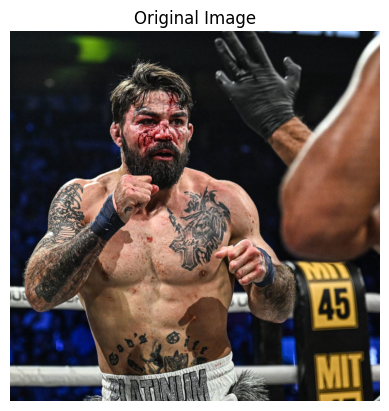

In [5]:
# Display the OG image
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [6]:
# Load pre-trained image detection model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
# Define the object detection function with simplified filtering
def detect_fighters(image, model, threshold=0.9):
    image_np = np.array(image)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image_np).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image_tensor)

    scores = outputs[0]['scores']
    boxes = outputs[0]['boxes']
    labels = outputs[0]['labels']

    # Filter boxes with a score above the threshold and person class label
    high_confidence_indices = torch.where((scores > threshold) & (labels == 1))[0]

    if len(high_confidence_indices) == 0:
        return []  # No detections

    detected_fighters = []

    for idx in high_confidence_indices:
        box = boxes[idx].detach().numpy()
        label = labels[idx].detach().numpy()
        print(f"Detected fighter: box={box}, label={label}, score={scores[idx].item()}")
        center_x = int((box[0] + box[2]) / 2)
        center_y = int((box[1] + box[3]) / 2)
        detected_fighters.append(((center_x, center_y), box))

    return detected_fighters

In [8]:
# Detect the fighters in the image
detected_fighters = detect_fighters(image_rgb, model)

Detected fighter: box=[  30.434921   89.18312   957.3274   1180.3518  ], label=1, score=0.9960964322090149


In [9]:
# Visualize the bounding boxes on the original image
def draw_bounding_boxes(image, boxes):
    image_pil = image.convert("RGBA")
    draw = ImageDraw.Draw(image_pil)
    for box in boxes:
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=10)
    return np.array(image_pil.convert("RGB"))

In [10]:
if detected_fighters:
    bounding_boxes = [box for _, box in detected_fighters]
    image_with_bbox = draw_bounding_boxes(image, bounding_boxes)
else:
    image_with_bbox = image_np
    print("No fighters detected")

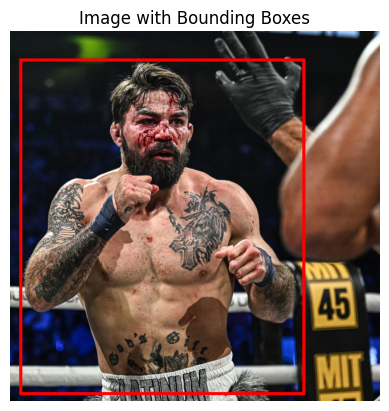

In [11]:
# Display the image with the bounding boxes
plt.imshow(image_with_bbox)
plt.title('Image with Bounding Boxes')
plt.axis('off')
plt.show()

Blue energy swirls link: 'https://wallpapers.com/images/hd/blue_-energy_-swirls_and_-lightning-91ot5yr9zxj4p6cy-2.jpg'

In [12]:
# URL for the effect image
effect_url = 'https://wallpapers.com/images/hd/blue_-energy_-swirls_and_-lightning-91ot5yr9zxj4p6cy-2.jpg'

# Load the effect image
effect_image = load_image(effect_url)

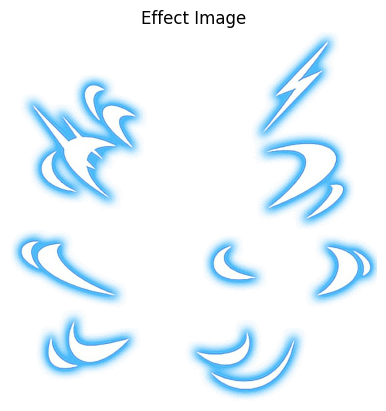

In [13]:
# Display the effect image
plt.imshow(effect_image)
plt.title('Effect Image')
plt.axis('off')
plt.show()

In [14]:
# Function to overlay the effect image
def overlay_effects(image, effect_image, detected_fighters):
    image_pil = image.convert("RGBA")

    for center, box in detected_fighters:
        # Scale the effect image to the size of the bounding box
        box_width = int(box[2] - box[0])
        box_height = int(box[3] - box[1])
        effect_resized = effect_image.resize((box_width, box_height), Image.LANCZOS)
        effect_center = (center[0] - effect_resized.width // 2, center[1] - effect_resized.height // 2)

        # Create an empty image with RGBA mode
        overlay_image = Image.new("RGBA", image_pil.size)
        overlay_image.paste(effect_resized, effect_center, effect_resized)

        # Combine the images
        image_pil = Image.alpha_composite(image_pil, overlay_image)

    return np.array(image_pil.convert("RGB"))

In [15]:
# Apply the effect to all detected fighters
if detected_fighters:
    image_with_effects = overlay_effects(image, effect_image, detected_fighters)
else:
    image_with_effects = image_np
    print("No fighters detected")

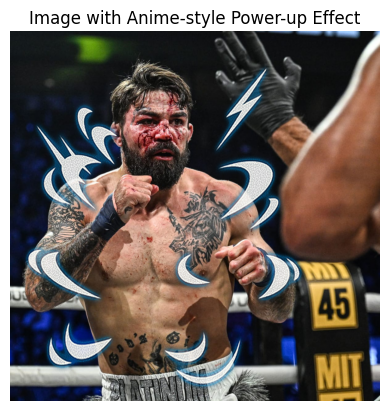

In [16]:
# Display the image with effects
plt.imshow(image_with_effects)
plt.title('Image with Anime-style Power-up Effect')
plt.axis('off')
plt.show()